# Import library

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


# Load Dataset

In [21]:
df = pd.read_csv("data/Wednesday-workingHours.pcap_ISCX.csv")
df.columns = df.columns.str.strip()

# Hilangkan kolom non-numerik & NaN
df = df.dropna()
X = df.select_dtypes(include=['float64', 'int64'])

# Select numeric columns
X = X.drop(columns=['Flow ID', 'Source IP', 'Destination IP', 'Timestamp'], errors='ignore')

# Ganti nilai inf/-inf menjadi NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Buang baris yang masih punya NaN setelah itu
X.dropna(inplace=True)

# Batasi nilai ekstrem agar tidak terlalu besar
X = X.clip(-1e10, 1e10)

# Ambil label asli jika ada (misal 'Label' atau 'Attack')
if 'Label' in df.columns:
    y_true = df['Label'].apply(lambda x: 0 if 'BENIGN' in x.upper() else 1)
else:
    y_true = None


# Select Features

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
sample_size = min(10000, len(X))  # ambil maksimal 10k atau semua jika datanya <10k
X_sample = X.sample(n=sample_size, random_state=42)

if y_true is not None:
    y_sample = y_true.loc[X_sample.index]
else:
    y_sample = None

print(f"Jumlah data diambil: {len(X_sample)} dari total {len(X)}")

Jumlah data diambil: 10000 dari total 691406


# Normaalisasi (StandardScaler)

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

In [24]:
# sample_size = min(10000, len(X_norm))  # Use max 10k samples
# sample_indices = np.random.choice(len(X_norm), sample_size, replace=False)

# df_sample = df.iloc[sample_indices].copy()
# X_scaled = X_norm[sample_indices]

# K-Means Clusterring

In [25]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)

print(f"K-Means Silhouette Score: {kmeans_silhouette}")

K-Means Silhouette Score: 0.9038007757777019


# DBSCAN Clusterring

In [26]:
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Hitung silhouette tanpa noise
if len(set(dbscan_labels)) > 1 and np.sum(dbscan_labels != -1) > 0:
    dbscan_silhouette = silhouette_score(X_scaled[dbscan_labels != -1],
                                         dbscan_labels[dbscan_labels != -1])
else:
    dbscan_silhouette = None

print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")  

DBSCAN Silhouette Score: 0.4034254288233156


# Visualisasi

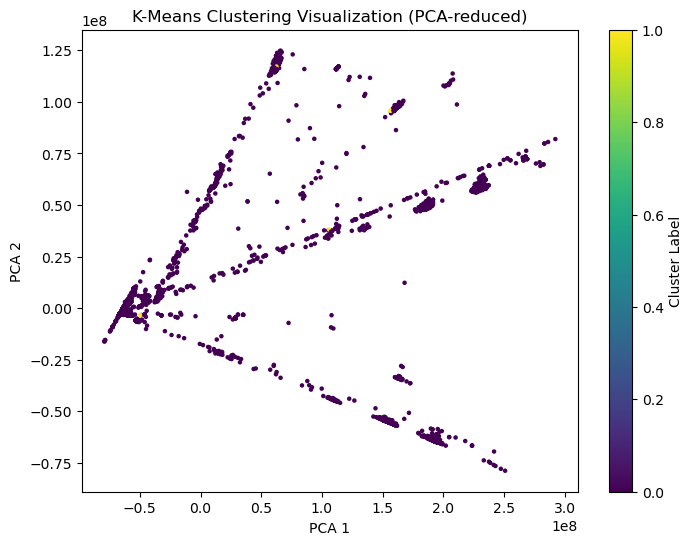

In [27]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_sample)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=kmeans_labels, cmap='viridis', s=5)
plt.colorbar(label='Cluster Label')
plt.title("K-Means Clustering Visualization (PCA-reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


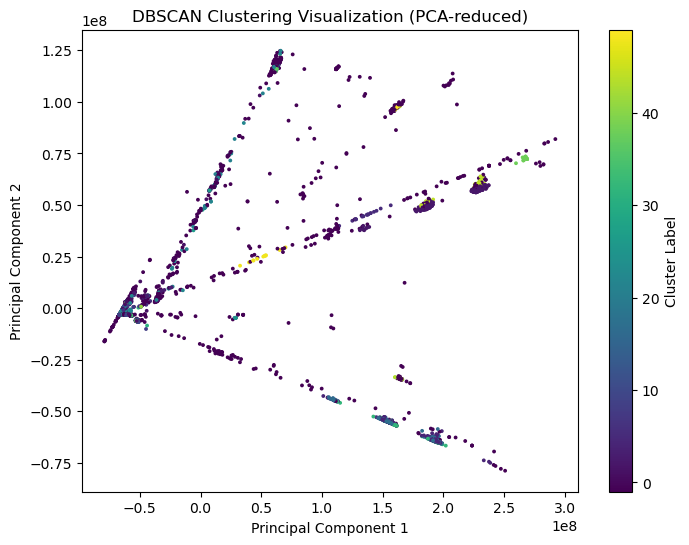

In [28]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_sample)

# Get DBSCAN cluster labels
labels = dbscan_labels

# Plot
plt.figure(figsize=(8,6))
plt.scatter(
    reduced[:, 0], reduced[:, 1],
    c=labels,
    cmap='viridis',
    s=3,
)

plt.title("DBSCAN Clustering Visualization (PCA-reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

# Analisis Fitur Pembeda (K-Means)

In [29]:
X_clustered = pd.DataFrame(X_scaled, columns=X_sample.columns)
X_clustered['Cluster'] = kmeans_labels
cluster_means = X_clustered.groupby('Cluster').mean()

# Urutkan fitur paling berbeda antar cluster
diff_features = (cluster_means.iloc[0] - cluster_means.iloc[1]).abs().sort_values(ascending=False).head(10)
print("\n🔍 Fitur yang paling membedakan antar cluster (K-Means):")
print(diff_features)


🔍 Fitur yang paling membedakan antar cluster (K-Means):
Bwd Header Length              30.916856
Total Backward Packets         30.352278
Subflow Bwd Packets            30.352278
Subflow Bwd Bytes              30.032503
Total Length of Bwd Packets    30.032503
Fwd Header Length              29.882460
Fwd Header Length.1            29.882460
Total Fwd Packets              28.874513
Subflow Fwd Packets            28.874513
act_data_pkt_fwd               19.499128
dtype: float64


# Analisis Noise DBSCAN

In [30]:
noise_ratio = np.sum(dbscan_labels == -1) / len(dbscan_labels)
print(f"\n🌀 Persentase noise ditemukan DBSCAN: {noise_ratio*100:.2f}%")


🌀 Persentase noise ditemukan DBSCAN: 14.60%


# Kesimpulan

In [31]:
print("\n📊 ======= KESIMPULAN =======")

if y_sample is not None:
    from sklearn.metrics import adjusted_rand_score
    ari_kmeans = adjusted_rand_score(y_sample, kmeans_labels)
    ari_dbscan = adjusted_rand_score(y_sample, dbscan_labels)
    print(f"Kecocokan dengan label asli (ARI): K-Means={ari_kmeans:.3f}, DBSCAN={ari_dbscan:.3f}")

print(f"\n1️⃣ Apakah cluster memisahkan normal vs serangan?")
if kmeans_silhouette > 0.3:
    print("✅ K-Means cukup berhasil memisahkan pola serangan vs normal.")
else:
    print("⚠️ K-Means kurang memisahkan dengan jelas.")

if dbscan_silhouette and dbscan_silhouette > 0.3:
    print("✅ DBSCAN juga menemukan pemisahan cluster yang cukup baik.")
else:
    print("⚠️ DBSCAN menghasilkan cluster yang tumpang tindih atau banyak noise.")

print(f"\n2️⃣ Apakah DBSCAN menemukan noise menarik?")
if noise_ratio > 0.05:
    print("🧩 Ya, DBSCAN mendeteksi sejumlah data anomali (potensi serangan baru).")
else:
    print("⚙️ Tidak banyak noise, dataset relatif bersih.")

print(f"\n3️⃣ Fitur pembeda utama:")
for feature in diff_features.index:
    print(f" - {feature}")

print(f"\n4️⃣ Apakah clustering membantu deteksi intrusi?")
if kmeans_silhouette > 0.3 or (dbscan_silhouette and dbscan_silhouette > 0.3):
    print("✅ Clustering dapat membantu eksplorasi awal untuk deteksi anomali & serangan.")
else:
    print("❌ Clustering saja belum cukup; perlu dikombinasikan dengan metode lain (misal supervised learning).")



📊 ======= KESIMPULAN =======
Kecocokan dengan label asli (ARI): K-Means=-0.001, DBSCAN=0.111

1️⃣ Apakah cluster memisahkan normal vs serangan?
✅ K-Means cukup berhasil memisahkan pola serangan vs normal.
✅ DBSCAN juga menemukan pemisahan cluster yang cukup baik.

2️⃣ Apakah DBSCAN menemukan noise menarik?
🧩 Ya, DBSCAN mendeteksi sejumlah data anomali (potensi serangan baru).

3️⃣ Fitur pembeda utama:
 - Bwd Header Length
 - Total Backward Packets
 - Subflow Bwd Packets
 - Subflow Bwd Bytes
 - Total Length of Bwd Packets
 - Fwd Header Length
 - Fwd Header Length.1
 - Total Fwd Packets
 - Subflow Fwd Packets
 - act_data_pkt_fwd

4️⃣ Apakah clustering membantu deteksi intrusi?
✅ Clustering dapat membantu eksplorasi awal untuk deteksi anomali & serangan.
